In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import warnings
warnings.filterwarnings('ignore')
from keras.datasets import cifar100
import cv2

In [ ]:
# ## Run following code in crm terminal
# C:\Users\ebsor\anaconda3\python.exe -m pip uninstall -y numpy pandas scipy scikit-learn numba shap tensorflow torch
# C:\Users\ebsor\anaconda3\python.exe -m pip install --no-cache-dir ^
# numpy==1.24.4 ^
# pandas==2.0.3 ^
# scipy==1.11.1 ^
# scikit-learn==1.3.2 ^
# numba==0.57.1 ^
# torch ^
# shap

# C:\Users\ebsor\anaconda3\python.exe -m pip install tensorflow==2.10.0 protobuf==3.19.6
# C:\Users\ebsor\anaconda3\python.exe -m pip install --no-cache-dir opencv-python==4.8.1.78

# import data

In [14]:
(X_train, y_train), (X_test, y_test) = cifar100.load_data(label_mode='coarse')

In [56]:
X_train.shape

(50000, 32, 32, 3)

# AlexNet model with X_train.shape = (sample, 224, 224, 3)

## resize image with cv2.resize() without data augmentation

In [7]:
# # Pre-allocate the array with the target shape
import gc
X_train_s = X_train[:2000]
y_train_s = y_train[:2000]

X_test_s  = X_test[:500]
y_test_s  = y_test[:500]


X_train_s_resized = np.zeros((2000, 224, 224, 3), dtype=np.uint8)
# Fill it incrementally
for i in range(len(X_train_s)):
    X_train_s_resized[i] = cv2.resize(X_train_s[i], (224, 224))
# Free original
del X_train_s
gc.collect()

# Pre-allocate the array with the target shape
X_test_s_resized = np.zeros((500, 224, 224, 3), dtype=np.uint8)
# Fill it incrementally
for i in range(len(X_test_s)):
    X_test_s_resized[i] = cv2.resize(X_test_s[i], (224, 224))
# Free original
del X_train
gc.collect()

# Convert to float32 and normalize
X_train_s = X_train_s_resized.astype(np.float32) / 255.0
X_test_s = X_test_s_resized.astype(np.float32) / 255.0

# Free uint8 arrays
del X_train_s_resized, X_test_s_resized
gc.collect()

0

In [9]:
### this code is ok but take a lot of time and it is very slow
input_layer = keras.layers.Input(shape=(224, 224, 3))

C1_layer = keras.layers.Conv2D(filters=96, kernel_size=(11, 11), strides=4, padding='SAME', activation='relu')(input_layer)
pool1_layer = keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='VALID')(C1_layer)

C2_layer = keras.layers.Conv2D(filters=256, kernel_size=(5, 5), strides=1, padding='SAME', activation='relu')(pool1_layer)
pool2_layer = keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='VALID')(C2_layer)

C3_layer = keras.layers.Conv2D(filters=384, kernel_size=(3, 3), strides=1, padding='SAME', activation='relu')(pool2_layer)
C4_layer = keras.layers.Conv2D(filters=384, kernel_size=(3, 3), strides=1, padding='SAME', activation='relu')(C3_layer)
C5_layer = keras.layers.Conv2D(filters=256, kernel_size=(3, 3), strides=1, padding='SAME', activation='relu')(C4_layer)

#flatten_layer = keras.layers.Flatten()(C5_layer)
flatten_layer = keras.layers.GlobalAveragePooling2D()(C5_layer)
Dens1_layer = keras.layers.Dense(4096, activation= 'relu')(flatten_layer)
Dens1_layer = keras.layers.Dropout(rate = 0.5)(Dens1_layer)

Dens2_layer = keras.layers.Dense(4096, activation= 'relu')(Dens1_layer)
Dens2_layer = keras.layers.Dropout(rate = 0.5)(Dens2_layer)

output_layer = keras.layers.Dense(20, activation= 'softmax')(Dens2_layer)

model = keras.Model(input_layer, output_layer)
model.compile(
    optimizer= keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
    loss= 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

callbacks = [
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,           # Reduce LR by half
        patience=3,           # Wait 3 epochs with no improvement
        min_lr=1e-6           # Minimum learning rate
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,          # Stop after 10 epochs without improvement
        restore_best_weights=True
    )
]
AlexNet_model = model.fit(X_train_s, y_train_s, epochs=25,batch_size= 64, validation_data=(X_test_s, y_test_s), callbacks=callbacks)

Epoch 1/10
63/63 [==============================] - 172s 3s/step - loss: 2.9870 - sparse_categorical_accuracy: 0.0565 - val_loss: 2.9381 - val_sparse_categorical_accuracy: 0.0620 - lr: 1.0000e-04
Epoch 2/10
63/63 [==============================] - 167s 3s/step - loss: 2.9252 - sparse_categorical_accuracy: 0.0815 - val_loss: 2.9106 - val_sparse_categorical_accuracy: 0.0840 - lr: 1.0000e-04
Epoch 3/10
63/63 [==============================] - 165s 3s/step - loss: 2.8651 - sparse_categorical_accuracy: 0.0890 - val_loss: 2.8938 - val_sparse_categorical_accuracy: 0.0800 - lr: 1.0000e-04
Epoch 4/10
63/63 [==============================] - 164s 3s/step - loss: 2.8361 - sparse_categorical_accuracy: 0.0900 - val_loss: 2.8242 - val_sparse_categorical_accuracy: 0.0860 - lr: 1.0000e-04
Epoch 5/10
63/63 [==============================] - 163s 3s/step - loss: 2.8056 - sparse_categorical_accuracy: 0.1100 - val_loss: 2.8504 - val_sparse_categorical_accuracy: 0.1020 - lr: 1.0000e-04
Epoch 6/10
63/63 [==

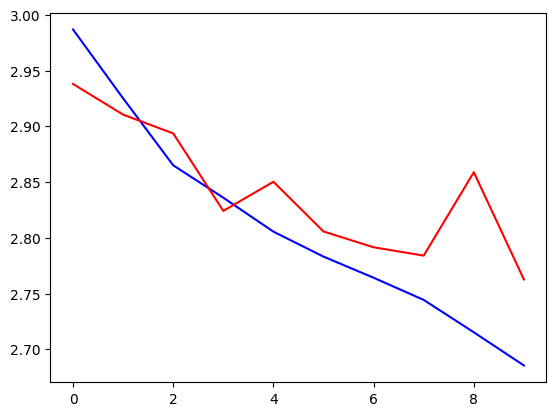

In [10]:
plt.plot(AlexNet_model.history['loss'], color='blue')
plt.plot(AlexNet_model.history['val_loss'], color='red')

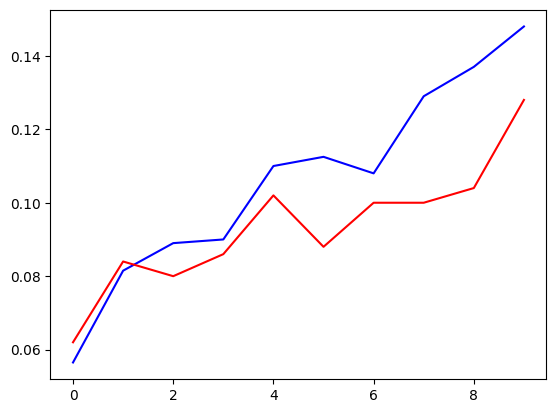

In [11]:
plt.plot(AlexNet_model.history['sparse_categorical_accuracy'], color='blue')
plt.plot(AlexNet_model.history['val_sparse_categorical_accuracy'], color='red')

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 56, 56, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 256)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 384)       885120

## resize with data_augumentation during training

In [16]:
X_train = X_train[:2000].astype(np.float32) / 255.0
y_train = y_train[:2000]

X_test = X_test[:500].astype(np.float32) / 255.0
y_test = y_test[:500]

In [39]:
data_augmentation = keras.Sequential([
    keras.layers.Resizing(224, 224),
    keras.layers.RandomFlip('horizontal'),
    keras.layers.RandomTranslation(
        height_factor=0.1,
        width_factor=0.1
    )#,
    # keras.layers.RandomBrightness(factor=0.2),
    # keras.layers.RandomContrast(factor=0.2)

], name="data_augmentation")

In [40]:
input_layer = keras.layers.Input(shape=(32, 32, 3))
X = data_augmentation(input_layer)

C1_layer = keras.layers.Conv2D(filters=96, kernel_size=(11, 11), strides=4, padding='SAME')(X)
C1_layer = keras.layers.Activation('relu')(C1_layer)
pool1_layer = keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='VALID')(C1_layer)
# pool1_layer = keras.layers.BatchNormalization()(pool1_layer)

C2_layer = keras.layers.Conv2D(filters=256, kernel_size=(5, 5), strides=1, padding='SAME')(pool1_layer)
C2_layer = keras.layers.Activation('relu')(C2_layer)
pool2_layer = keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='VALID')(C2_layer)
# pool2_layer = keras.layers.BatchNormalization()(pool2_layer)

C3_layer = keras.layers.Conv2D(filters=384, kernel_size=(3, 3), strides=1, padding='SAME')(pool2_layer)
C3_layer = keras.layers.Activation('relu')(C3_layer)
# C3_layer = keras.layers.BatchNormalization()(C3_layer)

C4_layer = keras.layers.Conv2D(filters=384, kernel_size=(3, 3), strides=1, padding='SAME')(C3_layer)
C4_layer = keras.layers.Activation('relu')(C4_layer)
# C4_layer = keras.layers.BatchNormalization()(C4_layer)

C5_layer = keras.layers.Conv2D(filters=256, kernel_size=(3, 3), strides=1, padding='SAME')(C4_layer)
C5_layer = keras.layers.Activation('relu')(C5_layer)
# C5_layer = keras.layers.BatchNormalization()(C5_layer)

#flatten_layer = keras.layers.Flatten()(C5_layer)
flatten_layer = keras.layers.GlobalAveragePooling2D()(C5_layer)
Dens1_layer = keras.layers.Dense(4096, activation= 'relu')(flatten_layer)
Dens1_layer = keras.layers.Dropout(rate = 0.5)(Dens1_layer)
# Dens1_layer = keras.layers.BatchNormalization()(Dens1_layer)

Dens2_layer = keras.layers.Dense(4096, activation= 'relu')(Dens1_layer)
Dens2_layer = keras.layers.Dropout(rate = 0.5)(Dens2_layer)
# Dens2_layer = keras.layers.BatchNormalization()(Dens2_layer)

output_layer = keras.layers.Dense(20, activation= 'softmax')(Dens2_layer)

model = keras.Model(input_layer, output_layer)
model.compile(
    optimizer= keras.optimizers.Adam(learning_rate=0.0001),
    loss= 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

In [35]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 conv2d_25 (Conv2D)          (None, 56, 56, 96)        34944     
                                                                 
 activation_20 (Activation)  (None, 56, 56, 96)        0         
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 27, 27, 96)       0         
 g2D)                                                            
                                                                 
 batch_normalization_7 (Batc  (None, 27, 27, 96)       384 

In [41]:
callbacks = [
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,           # Reduce LR by half
        patience=3,           # Wait 3 epochs with no improvement
        min_lr=1e-6           # Minimum learning rate
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,          # Stop after 10 epochs without improvement
        restore_best_weights=True
    )
]
AlexNet_model = model.fit(X_train, y_train, epochs=25,batch_size= 64, validation_data=(X_test, y_test), callbacks=callbacks)

Epoch 1/25
32/32 [==============================] - 126s 4s/step - loss: 2.9957 - sparse_categorical_accuracy: 0.0490 - val_loss: 2.9962 - val_sparse_categorical_accuracy: 0.0460 - lr: 1.0000e-04
Epoch 2/25
32/32 [==============================] - 142s 4s/step - loss: 2.9950 - sparse_categorical_accuracy: 0.0570 - val_loss: 2.9972 - val_sparse_categorical_accuracy: 0.0440 - lr: 1.0000e-04
Epoch 3/25
32/32 [==============================] - 164s 5s/step - loss: 2.9941 - sparse_categorical_accuracy: 0.0565 - val_loss: 3.0017 - val_sparse_categorical_accuracy: 0.0460 - lr: 1.0000e-04
Epoch 4/25
32/32 [==============================] - 176s 6s/step - loss: 2.9928 - sparse_categorical_accuracy: 0.0600 - val_loss: 3.0033 - val_sparse_categorical_accuracy: 0.0460 - lr: 1.0000e-04
Epoch 5/25
32/32 [==============================] - 165s 5s/step - loss: 2.9922 - sparse_categorical_accuracy: 0.0605 - val_loss: 3.0037 - val_sparse_categorical_accuracy: 0.0460 - lr: 5.0000e-05
Epoch 6/25
32/32 [==

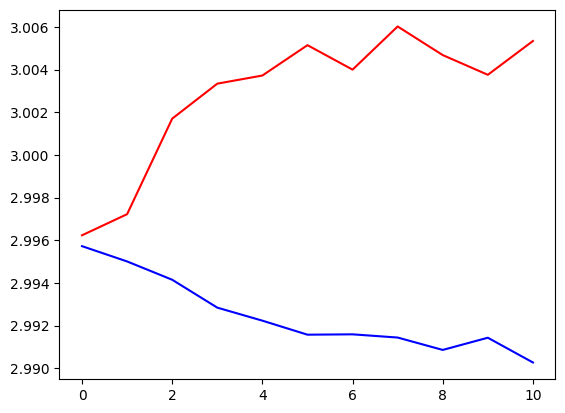

In [42]:
plt.plot(AlexNet_model.history['loss'], color='blue')
plt.plot(AlexNet_model.history['val_loss'], color='red')

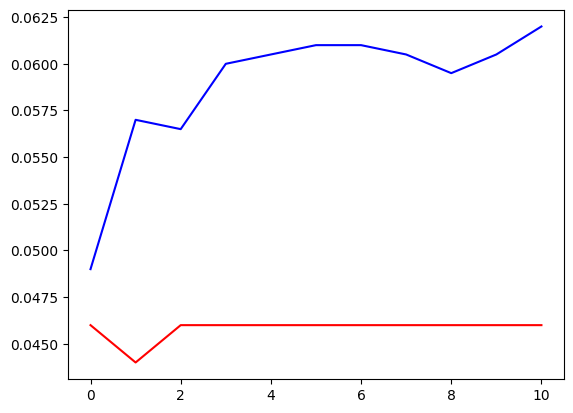

In [43]:
plt.plot(AlexNet_model.history['sparse_categorical_accuracy'], color='blue')
plt.plot(AlexNet_model.history['val_sparse_categorical_accuracy'], color='red')

## resize image with tf.image.resize()

In [36]:
# ## Another way
# def preprocess(img, label):
#     img = tf.image.resize(img, (224, 224))
#     img = tf.cast(img, tf.float32) / 255.0
#     return img, label

# train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
# train_ds = train_ds.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)

# test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
# test_ds = test_ds.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)

In [50]:
train_ds_small = train_ds.take(20)   
test_ds_small  = test_ds.take(5)

input_layer = keras.layers.Input(shape=(224, 224, 3))

C1_layer = keras.layers.Conv2D(filters=96, kernel_size=(11, 11), strides=4, padding='SAME')(input_layer)
C1_layer = keras.layers.Activation('relu')(C1_layer)
pool1_layer = keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='VALID')(C1_layer)
# pool1_layer = keras.layers.BatchNormalization()(pool1_layer)

C2_layer = keras.layers.Conv2D(filters=256, kernel_size=(5, 5), strides=1, padding='SAME')(pool1_layer)
C2_layer = keras.layers.Activation('relu')(C2_layer)
pool2_layer = keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='VALID')(C2_layer)
# pool2_layer = keras.layers.BatchNormalization()(pool2_layer)

C3_layer = keras.layers.Conv2D(filters=384, kernel_size=(3, 3), strides=1, padding='SAME')(pool2_layer)
C3_layer = keras.layers.Activation('relu')(C3_layer)
# C3_layer = keras.layers.BatchNormalization()(C3_layer)

C4_layer = keras.layers.Conv2D(filters=384, kernel_size=(3, 3), strides=1, padding='SAME')(C3_layer)
C4_layer = keras.layers.Activation('relu')(C4_layer)
# C4_layer = keras.layers.BatchNormalization()(C4_layer)

C5_layer = keras.layers.Conv2D(filters=256, kernel_size=(3, 3), strides=1, padding='SAME')(C4_layer)
C5_layer = keras.layers.Activation('relu')(C5_layer)
# C5_layer = keras.layers.BatchNormalization()(C5_layer)

#flatten_layer = keras.layers.Flatten()(C5_layer)
flatten_layer = keras.layers.GlobalAveragePooling2D()(C5_layer)
Dens1_layer = keras.layers.Dense(4096, activation= 'relu')(flatten_layer)
Dens1_layer = keras.layers.Dropout(rate = 0.5)(Dens1_layer)
# Dens1_layer = keras.layers.BatchNormalization()(Dens1_layer)

Dens2_layer = keras.layers.Dense(4096, activation= 'relu')(Dens1_layer)
Dens2_layer = keras.layers.Dropout(rate = 0.5)(Dens2_layer)
# Dens2_layer = keras.layers.BatchNormalization()(Dens2_layer)

output_layer = keras.layers.Dense(20, activation= 'softmax')(Dens2_layer)

model = keras.Model(input_layer, output_layer)
model.compile(
    optimizer= keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
    loss= 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

callbacks = [
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,           # Reduce LR by half
        patience=3,           # Wait 3 epochs with no improvement
        min_lr=1e-6           # Minimum learning rate
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,          # Stop after 10 epochs without improvement
        restore_best_weights=True
    )
]
AlexNet_model = model.fit(train_ds_small, epochs=10, validation_data=test_ds_small, callbacks=callbacks)

Epoch 1/10
20/20 [==============================] - 56s 3s/step - loss: 2.9968 - sparse_categorical_accuracy: 0.0516 - val_loss: 2.9925 - val_sparse_categorical_accuracy: 0.0500 - lr: 1.0000e-04
Epoch 2/10
20/20 [==============================] - 52s 3s/step - loss: 2.9874 - sparse_categorical_accuracy: 0.0703 - val_loss: 2.9835 - val_sparse_categorical_accuracy: 0.0500 - lr: 1.0000e-04
Epoch 3/10
20/20 [==============================] - 52s 3s/step - loss: 2.9817 - sparse_categorical_accuracy: 0.0625 - val_loss: 2.9612 - val_sparse_categorical_accuracy: 0.0500 - lr: 1.0000e-04
Epoch 4/10
20/20 [==============================] - 53s 3s/step - loss: 2.9339 - sparse_categorical_accuracy: 0.0875 - val_loss: 2.9161 - val_sparse_categorical_accuracy: 0.1562 - lr: 1.0000e-04
Epoch 5/10
20/20 [==============================] - 53s 3s/step - loss: 2.8914 - sparse_categorical_accuracy: 0.1031 - val_loss: 2.8614 - val_sparse_categorical_accuracy: 0.1500 - lr: 1.0000e-04
Epoch 6/10
20/20 [=======

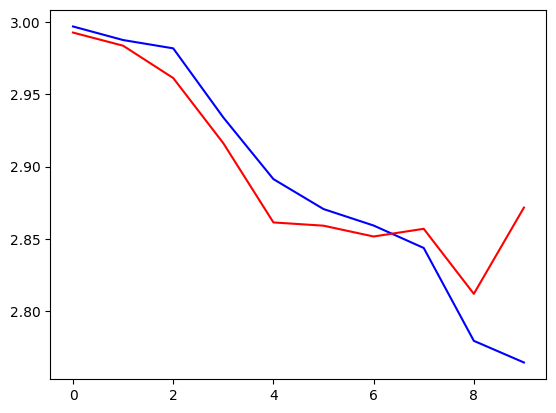

In [51]:
plt.plot(AlexNet_model.history['loss'], color='blue')
plt.plot(AlexNet_model.history['val_loss'], color='red')

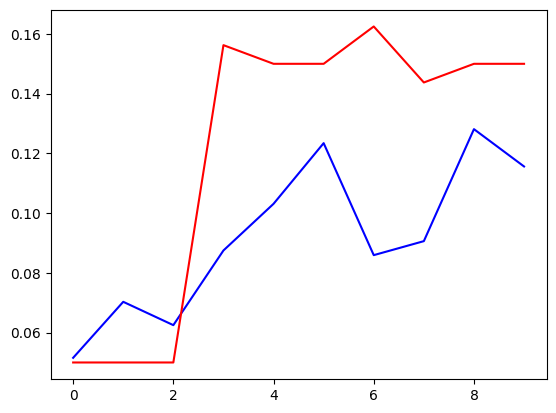

In [52]:
plt.plot(AlexNet_model.history['sparse_categorical_accuracy'], color='blue')
plt.plot(AlexNet_model.history['val_sparse_categorical_accuracy'], color='red')

In [54]:
model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_47 (Conv2D)          (None, 56, 56, 96)        34944     
                                                                 
 activation_7 (Activation)   (None, 56, 56, 96)        0         
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 27, 27, 96)       0         
 g2D)                                                            
                                                                 
 conv2d_48 (Conv2D)          (None, 27, 27, 256)       614656    
                                                                 
 activation_8 (Activation)   (None, 27, 27, 256)       0         
                                                           

# AlexNet model with X_train.shape = (50000, 140, 140, 3)

In [58]:
X_train_s = X_train[:2000]
y_train_s = y_train[:2000]

X_test_s  = X_test[:500]
y_test_s  = y_test[:500]

X_train_s = X_train_s.astype(np.float32) / 255.0
X_test_s = X_test_s.astype(np.float32) / 255.0

X_train_s = np.array([cv2.resize(img, (140, 140)) for img in X_train_s])
X_test_s = np.array([cv2.resize(img, (140, 140)) for img in X_test_s])


input_layer = keras.layers.Input(shape=(140, 140, 3))

C1_layer = keras.layers.Conv2D(filters=32, kernel_size=(11, 11), strides=4, padding='SAME')(input_layer)
C1_layer = keras.layers.Activation('relu')(C1_layer)
pool1_layer = keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='VALID')(C1_layer)
pool1_layer = keras.layers.BatchNormalization()(pool1_layer)

C2_layer = keras.layers.Conv2D(filters=64, kernel_size=(5, 5), strides=1, padding='SAME')(pool1_layer)
C2_layer = keras.layers.Activation('relu')(C2_layer)
pool2_layer = keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='VALID')(C2_layer)
pool2_layer = keras.layers.BatchNormalization()(pool2_layer)

C3_layer = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), strides=1, padding='SAME')(pool2_layer)
C3_layer = keras.layers.Activation('relu')(C3_layer)
C3_layer = keras.layers.BatchNormalization()(C3_layer)

C4_layer = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), strides=1, padding='SAME')(C3_layer)
C4_layer = keras.layers.Activation('relu')(C4_layer)
C4_layer = keras.layers.BatchNormalization()(C4_layer)

C5_layer = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='SAME')(C4_layer)
C5_layer = keras.layers.Activation('relu')(C5_layer)
C5_layer = keras.layers.BatchNormalization()(C5_layer)

#flatten_layer = keras.layers.Flatten()(C5_layer)
flatten_layer = keras.layers.GlobalAveragePooling2D()(C5_layer)
Dens1_layer = keras.layers.Dense(512, activation= 'relu')(flatten_layer)
Dens1_layer = keras.layers.Dropout(rate = 0.5)(Dens1_layer)
# Dens1_layer = keras.layers.BatchNormalization()(Dens1_layer)

Dens2_layer = keras.layers.Dense(512, activation= 'relu')(Dens1_layer)
Dens2_layer = keras.layers.Dropout(rate = 0.5)(Dens2_layer)
Dens2_layer = keras.layers.BatchNormalization()(Dens2_layer)

output_layer = keras.layers.Dense(20, activation= 'softmax')(Dens2_layer)

model = keras.Model(input_layer, output_layer)
model.compile(
    optimizer= keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
    loss= 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

callbacks = [
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,           # Reduce LR by half
        patience=3,           # Wait 3 epochs with no improvement
        min_lr=1e-6           # Minimum learning rate
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,          # Stop after 10 epochs without improvement
        restore_best_weights=True
    )
]
AlexNet_model = model.fit(X_train_s, y_train_s, epochs=10, validation_data=(X_test_s, y_test_s), callbacks=callbacks)

Epoch 1/10
63/63 [==============================] - 111s 2s/step - loss: 3.5102 - sparse_categorical_accuracy: 0.0725 - val_loss: 3.0009 - val_sparse_categorical_accuracy: 0.0380 - lr: 1.0000e-04
Epoch 2/10
63/63 [==============================] - 21s 320ms/step - loss: 3.3535 - sparse_categorical_accuracy: 0.0915 - val_loss: 3.0051 - val_sparse_categorical_accuracy: 0.0460 - lr: 1.0000e-04
Epoch 3/10
63/63 [==============================] - 15s 236ms/step - loss: 3.2396 - sparse_categorical_accuracy: 0.1120 - val_loss: 2.9844 - val_sparse_categorical_accuracy: 0.0680 - lr: 1.0000e-04
Epoch 4/10
63/63 [==============================] - 15s 246ms/step - loss: 3.2067 - sparse_categorical_accuracy: 0.1070 - val_loss: 2.9731 - val_sparse_categorical_accuracy: 0.0760 - lr: 1.0000e-04
Epoch 5/10
63/63 [==============================] - 17s 264ms/step - loss: 3.1118 - sparse_categorical_accuracy: 0.1390 - val_loss: 3.0234 - val_sparse_categorical_accuracy: 0.0820 - lr: 1.0000e-04
Epoch 6/10
6

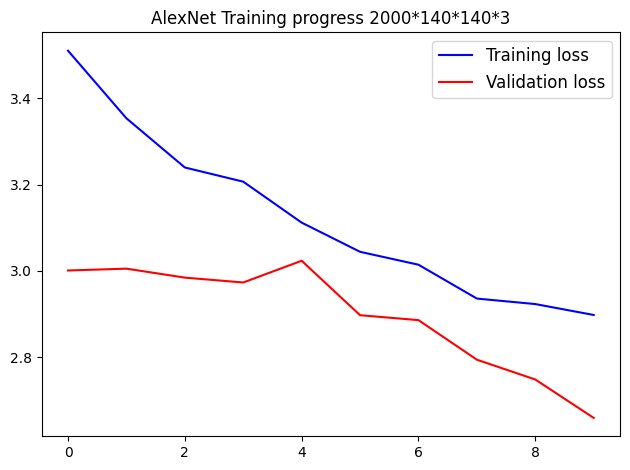

In [65]:
plt.plot(AlexNet_model.history['loss'], color='blue')
plt.plot(AlexNet_model.history['val_loss'], color='red')
plt.title('AlexNet Training progress 2000*140*140*3')
plt.legend(['Training loss', 'Validation loss'], loc='best', fontsize=12)
plt.tight_layout()
plt.show()

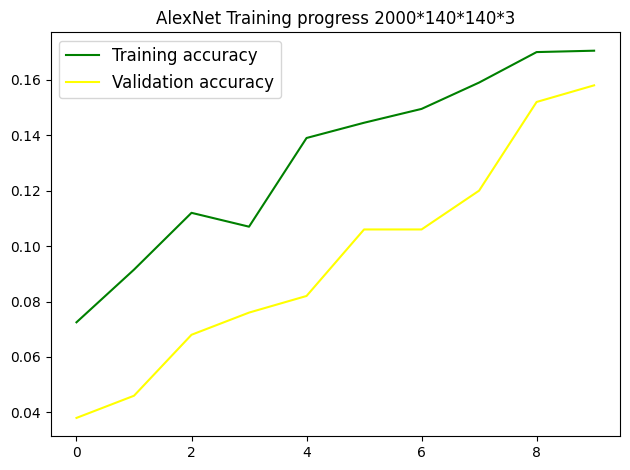

In [66]:
plt.plot(AlexNet_model.history['sparse_categorical_accuracy'], color='green')
plt.plot(AlexNet_model.history['val_sparse_categorical_accuracy'], color='yellow')
plt.title('AlexNet Training progress 2000*140*140*3')
plt.legend(['Training accuracy', 'Validation accuracy'], loc='best', fontsize=12)
plt.tight_layout()
plt.show()

In [67]:
model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 140, 140, 3)]     0         
                                                                 
 conv2d_52 (Conv2D)          (None, 35, 35, 32)        11648     
                                                                 
 activation_12 (Activation)  (None, 35, 35, 32)        0         
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 17, 17, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_8 (Batc  (None, 17, 17, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_53 (Conv2D)          (None, 17, 17, 64)        512

ValueError: Could not save to JPEG for display

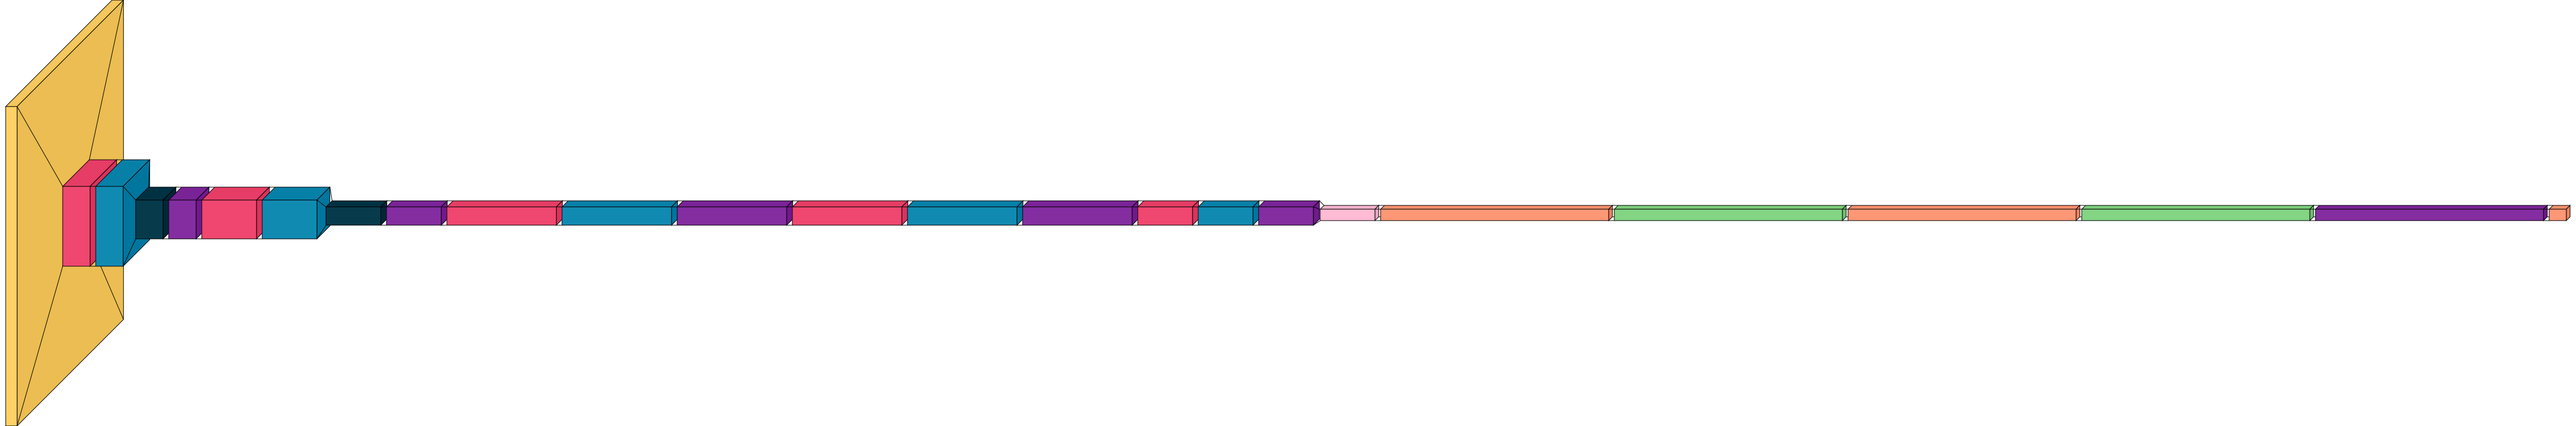

In [68]:
import visualkeras
visualkeras.layered_view(model)